# Including low S/N stars.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

import aviary as av
import astropy.modeling as apm

from tqdm import trange
import pickle

from cv_routines import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [58]:
young_limit = .7  # .1 is worse.
old_limit = 20.
hot_limit = 1.
dp, dc = .05, .05
cluster_old_err = .05  # The relative prot uncertainty on Ruprecht 147 and NGC6819
kinerr = .05 # The relative prot uncertainty on kinematic grid periods. .1 was worse. .03 also worse, but better MAD (bad at old ages).
abs_kinerr = 2.
sun_err = .01  # The absolute prot uncertainty on the Sun's rotation period.
sun_color=.82
sun_prot=26.
sun_age=4.56

Kinematic ages

In [59]:
k = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
k_lucy = pd.read_csv("../data/Gyrokinage2020_Prot.csv")
kl = pd.DataFrame(dict({"kepid": k_lucy.kepid.values,
                        "kin_age_lucy": k_lucy.kin_age.values,
                        "kin_age_err": k_lucy.kin_age_err.values}))
k = pd.merge(k, kl, on="kepid", how="left")

# Remove subgiants and photometric binaries
kin = k.iloc[k.flag.values == 1]
finite = np.isfinite(kin.Prot.values) \
    & np.isfinite(kin.bprp_dered.values) \
    & np.isfinite(kin.kin_age_lucy.values)
kin = kin.iloc[finite]

ap = pd.read_csv("../../data/aperiodic_ages.csv")
ap = ap.iloc[ap.w.values > .15]
ap["kin_age_lucy"] = ap.kin_age.values

kin = pd.merge(kin, ap, how="outer", on=["kepid", "Prot", "bprp_dered", "kin_age_lucy", "age", "Prot_err"])
print(np.shape(kin), np.shape(akin), np.shape(ap))

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (113) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(28388, 360) (10676, 360) (7611, 159)


In [60]:
# Remove stars bluer than 1.5 and with kinematic ages greater than 6 as
# these are likely to be subgiants.
subs = (kin.bprp_dered.values < 1.5) & (kin.kinematic_age.values > 6)
kin = kin.iloc[~subs]

# Remove stars that fall beneath the lower envelope using the
# Angus + (2019) gyro relation and stars kinematically older than
# old_limit.
no_young = (kin.age.values > young_limit) \
    & (kin.kin_age_lucy.values < old_limit)
kin = kin.iloc[no_young]

# Remove hot stars as the clusters provide better coverage.
cool = kin.bprp_dered.values > hot_limit
akin = kin.iloc[cool]

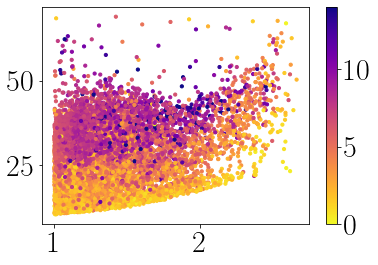

In [61]:
plt.scatter(akin.bprp_dered, akin.Prot, c=akin.kin_age_lucy, s=10, vmin=0, vmax=14, cmap="plasma_r")
plt.colorbar()

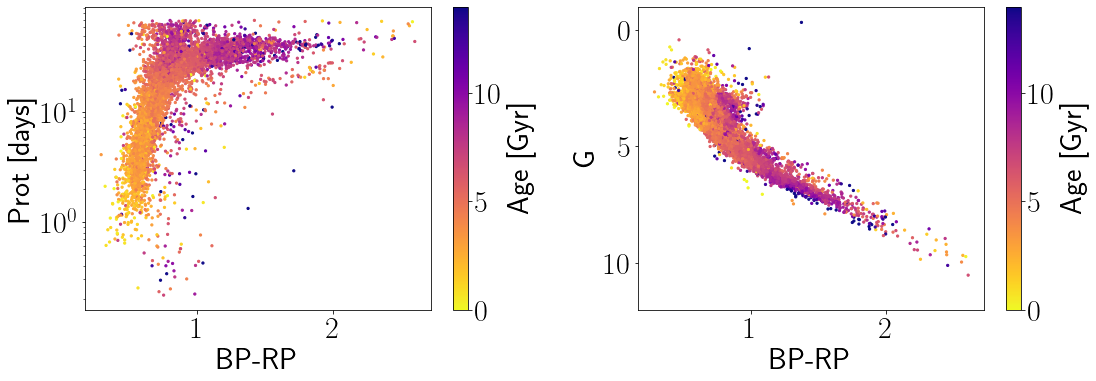

In [72]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(ap.bprp_dered, ap.Prot, c=ap.kin_age, s=5, cmap="plasma_r", vmin=0, vmax=14)
plt.yscale("log")
plt.colorbar(label="Age [Gyr]");
plt.xlabel("BP-RP")
plt.ylabel("Prot [days]")
plt.subplot(1, 2, 2)
plt.scatter(ap.bprp_dered, ap.abs_G, c=ap.kin_age, vmin=0, vmax=14, s=5, cmap="plasma_r")
plt.colorbar(label="Age [Gyr]");
plt.xlabel("BP-RP")
plt.ylabel("G")
plt.ylim(12, -1)
plt.tight_layout()

In [73]:
# Create grid of kinematic data
logp = np.log10(akin.Prot.values)
pgrid = np.arange(min(logp), max(logp), dp)
cgrid = np.arange(min(akin.bprp_dered.values),
                  max(akin.bprp_dered.values), dc)
P, C = np.meshgrid(pgrid, cgrid)
A = np.zeros_like(P)
prot_errs, npoints = [np.zeros_like(P) for i in range(2)]
for i in range(np.shape(A)[0]):
    for j in range(np.shape(A)[1]):
        b = (logp - .5*dp < P[i, j]) & (P[i, j] < logp + .5*dp)
        b &= (akin.bprp_dered.values - .5*dc < C[i, j]) \
            & (C[i, j] < akin.bprp_dered.values + .5*dc)
        A[i, j] = np.median(akin.kin_age_lucy.values[b])
        prot_errs[i, j] = np.sqrt(sum((akin.Prot_err.values[b]
                                       /akin.Prot.values[b])**2)) \
            / np.sqrt(float(len(akin.kin_age_lucy.values[b])))
        npoints[i, j] = len(akin.kin_age_lucy.values[b])

finite = np.isfinite(C) & np.isfinite(P) & np.isfinite(A) \
    & np.isfinite(prot_errs)
morethan = npoints[finite] > 1
C, P, A, prot_errs = C[finite][morethan], P[finite][morethan], \
    A[finite][morethan], prot_errs[finite][morethan]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Clusters.

In [74]:
# Load cluster data from Get_cluster_scatter and add the Sun.
cluster_uncert = pd.read_csv("../data/clusters_with_uncertainties.csv")
cluster_x = np.concatenate((cluster_uncert.bprp.values,
                            np.array([sun_color])))
cluster_prot = np.concatenate((cluster_uncert.prot.values,
                               np.array([sun_prot])))
cluster_age = np.concatenate((cluster_uncert.age.values,
                              np.array([sun_age])))
cluster_prot_errs = np.concatenate((cluster_uncert.prot_err.values,
                                    np.array([sun_err])))

# Decrease the uncertainties on the oldest clusters to cluster_old_err
select_old = cluster_age > 2.
cluster_prot_errs[select_old] = np.ones(len(
    cluster_prot_errs[select_old])) * cluster_old_err

# Combine clusters with kinematic grid
x = np.concatenate((cluster_x, np.ndarray.flatten(C)))
prot_err = np.concatenate((cluster_prot_errs,
#                            np.ones(len(np.ndarray.flatten(10**P)))
#                            *abs_kinerr))
                           np.ndarray.flatten(10**P)*kinerr))
prot = np.concatenate((cluster_prot, np.ndarray.flatten(10**P)))
age = np.concatenate((cluster_age, np.ndarray.flatten(A)))
ID = np.concatenate((np.zeros_like(cluster_age),
                     np.ones_like(np.ndarray.flatten(A))))

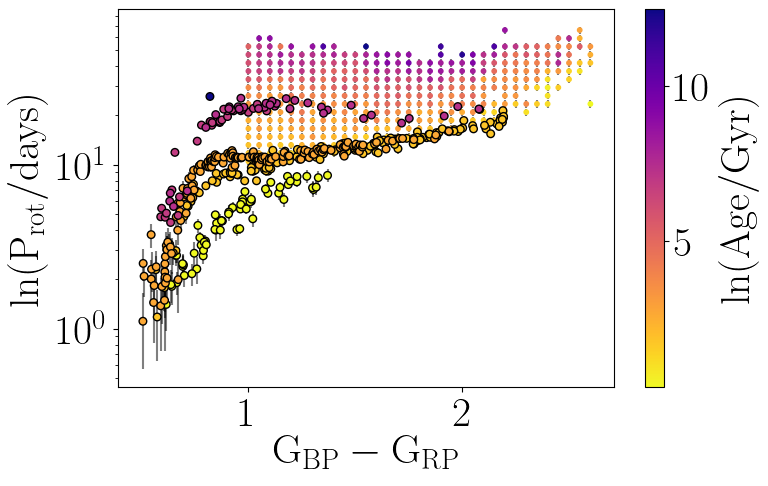

In [75]:
plt.figure(figsize=(8, 5), dpi=100)
plt.errorbar(x, prot, yerr=prot_err, fmt=".", color="k", alpha=.5, ms=1, zorder=0)
plt.scatter(x[ID==0], prot[ID==0], c=age[ID==0], s=30, edgecolor="k", cmap="plasma_r", zorder=2)
plt.scatter(x[ID==1], prot[ID==1], c=age[ID==1], s=10, cmap="plasma_r", zorder=1)
plt.xlabel("$$\mathrm{G_{BP}-G_{RP}}$$")
plt.ylabel("$\mathrm{ln(P_{rot}/days)}$")
plt.colorbar(label="$\mathrm{ln(Age/Gyr)}$")
plt.yscale("log")

In [ ]:
filename = "../data/lowSN_gp_model.pkl"
map_soln = av.fit_gp(x, age, prot, prot_err, filename)

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1156.782550848617 -> -1152.8434054329155
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1152.8434054329155 -> -1152.1641506236838
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1152.1641506236838 -> -1149.9073577997697
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1149.9073577997697 -> -1148.0868290644307
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1148.0868290644307 -> 223.71764123722426
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


In [ ]:
mu, sig, mu_fit = get_stellar_ages(x, prot, prot_err, filename)